In [1]:
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
# Chargement des données
data = pd.read_csv('train.csv')
data['comment_text'].head()


0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [4]:
# Toutes les catégories toxiques sont regroupées en une pour pouvoir faire un tableau avec colonne toxique et non_toxique
data['is_toxic'] = data.iloc[:, 2:].sum(axis=1) > 0

class_distribution = data['is_toxic'].value_counts()

class_distribution


is_toxic
False    143346
True      16225
Name: count, dtype: int64

In [5]:
from sklearn.utils import resample

# Séparation en toxiques et non toxiques
toxic_comments = data[data['is_toxic'] == True]
nontoxic_comments = data[data['is_toxic'] == False]

# Rééquilibrage toxique et non toxique
nontoxic_downsampled = resample(nontoxic_comments,
                                replace=False,
                                n_samples=len(toxic_comments),
                                random_state=42)

balanced_data = pd.concat([toxic_comments, nontoxic_downsampled])

balanced_distribution = balanced_data['is_toxic'].value_counts()
balanced_distribution
data_toxic = balanced_data

In [6]:
import re

def treat_comment(comment, index, total):
    # Supprimer les balises HTML
    comment = re.sub(r'<.*?>', '', comment)
    # Supprimer les URLs
    comment = re.sub(r'http\S+', '', comment)
    
    # Continuer avec le traitement SpaCy
    spacy_comment = nlp(comment, disable=["parser", "tagger", "ner", "textcat"])
    treated_tokens = []
    for w in spacy_comment:
        if w.is_alpha and not w.is_stop:
            treated_tokens.append(w.text)
    
    # Afficher la progression pour chaque commentaire traité
    if index % 100 == 0:
        print(f"Traitement du commentaire {index}/{total}...")  
    
    return " ".join(treated_tokens)

 # On applique la fonction à chaque ligne du DataFrame
total_comments = len(balanced_data)
balanced_data['treated_comment'] = [treat_comment(comment, index + 1, total_comments) for index, comment in enumerate(balanced_data['comment_text'])]


C:\Users\12mou\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Traitement du commentaire 100/32450...
Traitement du commentaire 200/32450...
Traitement du commentaire 300/32450...
Traitement du commentaire 400/32450...
Traitement du commentaire 500/32450...
Traitement du commentaire 600/32450...
Traitement du commentaire 700/32450...
Traitement du commentaire 800/32450...
Traitement du commentaire 900/32450...
Traitement du commentaire 1000/32450...
Traitement du commentaire 1100/32450...
Traitement du commentaire 1200/32450...
Traitement du commentaire 1300/32450...
Traitement du commentaire 1400/32450...
Traitement du commentaire 1500/32450...
Traitement du commentaire 1600/32450...
Traitement du commentaire 1700/32450...
Traitement du commentaire 1800/32450...
Traitement du commentaire 1900/32450...
Traitement du commentaire 2000/32450...
Traitement du commentaire 2100/32450...
Traitement du commentaire 2200/32450...
Traitement du commentaire 2300/32450...
Traitement du commentaire 2400/32450...
Traitement du commentaire 2500/32450...
Traitemen

Traitement du commentaire 20400/32450...
Traitement du commentaire 20500/32450...
Traitement du commentaire 20600/32450...
Traitement du commentaire 20700/32450...
Traitement du commentaire 20800/32450...
Traitement du commentaire 20900/32450...
Traitement du commentaire 21000/32450...
Traitement du commentaire 21100/32450...
Traitement du commentaire 21200/32450...
Traitement du commentaire 21300/32450...
Traitement du commentaire 21400/32450...
Traitement du commentaire 21500/32450...
Traitement du commentaire 21600/32450...
Traitement du commentaire 21700/32450...
Traitement du commentaire 21800/32450...
Traitement du commentaire 21900/32450...
Traitement du commentaire 22000/32450...
Traitement du commentaire 22100/32450...
Traitement du commentaire 22200/32450...
Traitement du commentaire 22300/32450...
Traitement du commentaire 22400/32450...
Traitement du commentaire 22500/32450...
Traitement du commentaire 22600/32450...
Traitement du commentaire 22700/32450...
Traitement du co

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()

# On sépare les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data['treated_comment'], 
    balanced_data['is_toxic'], 
    test_size=0.2, 
    random_state=42
)

# Adapter le vectorisateur à l'ensemble d'entraînement et le transformer
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Entraînement du modèle
X_train_tfidf.shape, X_test_tfidf.shape


((25960, 52129), (6490, 52129))

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# On utilise un modèle de classification car valeurs catégorielles
model = LogisticRegression(random_state=42)

# Entraînement du modèle
model.fit(X_train_tfidf, y_train)

# Prédiction des résultats
y_pred = model.predict(X_test_tfidf)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Générer un rapport de classification
report = classification_report(y_test, y_pred)
print(report)

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


Accuracy: 0.8895223420647149
              precision    recall  f1-score   support

       False       0.87      0.92      0.89      3229
        True       0.92      0.86      0.89      3261

    accuracy                           0.89      6490
   macro avg       0.89      0.89      0.89      6490
weighted avg       0.89      0.89      0.89      6490

[[2973  256]
 [ 461 2800]]


In [9]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

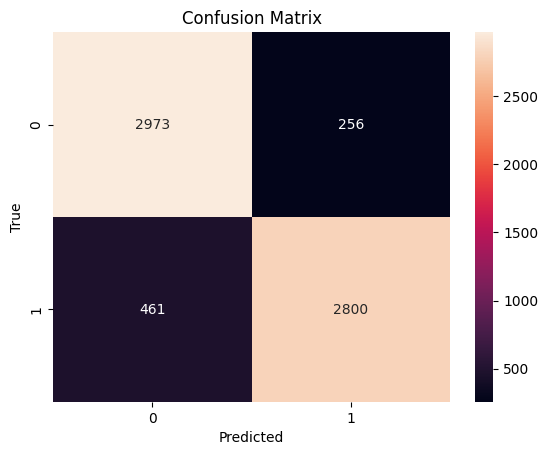

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle

y_pred = model.predict(X_test_tfidf)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred),annot = True ,fmt = 'g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Simulons le chargement du modèle et des données vectorisées pour l'ensemble de test

model = LogisticRegression(random_state=42)  # Remplacer par le modèle chargé
model.fit(X_train_tfidf, y_train)  # Remplacer par le modèle déjà entraîné

X_test_tfidf = tfidf_vectorizer.transform(X_test)  # A Remplacer par l'ensemble de test réel

# Obtenir les probabilités prédites pour l'ensemble de test
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]  # Proba de la classe 1 (toxique)

# Tester différents seuils pour trouver le meilleur équilibre pour la classe toxique
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Dictionnaire pour enregistrer les métriques pour chaque seuil
metrics = {}

# Boucle sur les différents seuils pour évaluer les effets
for threshold in thresholds:
    y_pred_new = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_new)
    report = classification_report(y_test, y_pred_new, target_names=['False', 'True'], output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred_new)
    
    metrics[threshold] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix
    }
# Afficher la précision et la matrice de confusion pour chaque seuil
metrics


{0.3: {'accuracy': 0.8477657935285053,
  'precision': 0.7806865892813041,
  'recall': 0.9693345599509353,
  'f1-score': 0.86484268125855,
  'confusion_matrix': array([[2341,  888],
         [ 100, 3161]], dtype=int64)},
 0.4: {'accuracy': 0.8892141756548536,
  'precision': 0.8679791546033584,
  'recall': 0.9193498926709598,
  'f1-score': 0.8929262844378257,
  'confusion_matrix': array([[2773,  456],
         [ 263, 2998]], dtype=int64)},
 0.5: {'accuracy': 0.8895223420647149,
  'precision': 0.9162303664921466,
  'recall': 0.8586323213738117,
  'f1-score': 0.8864967547886655,
  'confusion_matrix': array([[2973,  256],
         [ 461, 2800]], dtype=int64)},
 0.6: {'accuracy': 0.8684129429892141,
  'precision': 0.948899664304364,
  'recall': 0.7801287948482061,
  'f1-score': 0.856277347694379,
  'confusion_matrix': array([[3092,  137],
         [ 717, 2544]], dtype=int64)},
 0.7: {'accuracy': 0.8332819722650231,
  'precision': 0.9722583441699176,
  'recall': 0.6878258203005213,
  'f1-scor

In [12]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Vérifier que le nombre de caractéristiques est le même
print(f'Train features: {X_train_tfidf.shape[1]}')
print(f'Test features: {X_test_tfidf.shape[1]}')

# Si le modèle a été entraîné avec un certain nombre de caractéristiques, il doit recevoir le même nombre lors de la prédiction.


Train features: 52129
Test features: 52129


In [18]:
y_pred_final = (y_pred_proba >= 0.4).astype(int)

accuracy = accuracy_score(y_test, y_pred_final)
report = classification_report(y_test, y_pred_final, target_names=['Non-Toxique', 'Toxique'])
conf_matrix = confusion_matrix(y_test, y_pred_final)

print(f'Accuracy: {accuracy}')
print(report)
print(conf_matrix)


Accuracy: 0.8892141756548536
              precision    recall  f1-score   support

 Non-Toxique       0.91      0.86      0.89      3229
     Toxique       0.87      0.92      0.89      3261

    accuracy                           0.89      6490
   macro avg       0.89      0.89      0.89      6490
weighted avg       0.89      0.89      0.89      6490

[[2773  456]
 [ 263 2998]]


In [19]:
import pickle

# Enregistrer le modèle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Enregistrer le vectorisateur
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

# Enregistrer le seuil a cas où. On l'utilise pas dans notre projet
with open('threshold.pkl', 'wb') as file:
    pickle.dump(0.4, file)
